<a href="https://colab.research.google.com/github/daniloaleixo/UdacityMachineLearningTrading/blob/master/Strategy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portolio Rebalancing

* Choose the group of stocks
* Build a fixed individual position sized long only portfolio by picking **m** number of stocks based on monthly returns
* Rebalance the portfolio every month removing the worse **x** stocks and replacing them with top **x** stocks from the universe of stocks
* Backtest the strategy and compare the KPIs with that of simple buy and hold strategy 

In [0]:
# ==================================================================
# Backtesting strategy - I : Monthly portfolio rebalancing
# Author : Mayank Rasu
# ==================================================================

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import copy
import matplotlib.pyplot as plt

## KPIs

In [0]:
def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

## Download historical data

In [0]:
tickers = ["MMM","AXP","T","BA","CAT","CVX","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UTX","UNH","VZ","V","WMT","DIS"]

ohlc_mon = {} # directory with ohlc value for each stock            
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks whose data has been extracted from the ticker list
    for i in range(len(tickers)):
        try:
            ohlc_mon[tickers[i]] = pdr.get_data_yahoo(tickers[i],datetime.date.today()-datetime.timedelta(1900),datetime.date.today(),interval='m')
            ohlc_mon[tickers[i]].dropna(inplace = True)
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

## Backtesting

In [4]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]


# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(1,len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CVX
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UTX
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT


In [6]:
portfolio_return = pflio(return_df,6,3) 

['DIS', 'JPM', 'CSCO', 'GS', 'HD', 'PFE']
['DIS', 'GS', 'PFE', 'UNH', 'NKE', 'PFE']
['DIS', 'GS', 'NKE', 'MSFT', 'GE', 'CAT']
['DIS', 'GS', 'NKE', 'UNH', 'INTC', 'GS']
['DIS', 'NKE', 'NKE', 'DIS', 'JPM', 'T']
['NKE', 'NKE', 'V', 'TRV', 'PFE', 'NKE']
['NKE', 'NKE', 'NKE', 'AXP', 'GE', 'HD']
['NKE', 'NKE', 'NKE', 'NKE', 'INTC', 'MSFT']
['INTC', 'MSFT', 'MSFT', 'GE', 'CVX', 'TRV']
['MSFT', 'MSFT', 'GE', 'HD', 'JPM', 'GE']
['GE', 'GE', 'PG', 'UNH', 'MCD', 'WMT']
['PG', 'MCD', 'WMT', 'WMT', 'VZ', 'T']
['VZ', 'T', 'CAT', 'CSCO', 'UTX', 'IBM']
['CAT', 'CSCO', 'IBM', 'IBM', 'CVX', 'CAT']
['CAT', 'CVX', 'CAT', 'PFE', 'CVX', 'JPM']
['PFE', 'JPM', 'CSCO', 'MSFT', 'PFE', 'WMT']
['PFE', 'PFE', 'WMT', 'T', 'VZ', 'JNJ']
['PFE', 'PFE', 'JNJ', 'MSFT', 'CAT', 'HD']
['MSFT', 'CAT', 'HD', 'MRK', 'GS', 'JPM']
['MSFT', 'CAT', 'MRK', 'CAT', 'INTC', 'CVX']
['MSFT', 'MRK', 'CVX', 'GS', 'BA', 'MSFT']
['CVX', 'GS', 'BA', 'GS', 'JPM', 'CAT']
['GS', 'GS', 'JPM', 'GS', 'TRV', 'VZ']
['JPM', 'TRV', 'DIS', 'MRK', 'V',

In [11]:
#calculating overall strategy's KPIs
cagr = CAGR(portfolio_return)
SR  = sharpe(portfolio_return,0.025)
dd = max_dd(portfolio_return)

print("Portfolio ==> CAGR: ", cagr * 100, "% - sharpe: ", SR, " - dd: ", dd*100, "%")

Portfolio ==> CAGR:  11.570632561341165 % - sharpe:  0.6578355868332897  - dd:  16.057119560105367 %


In [12]:
#calculating KPIs for Index buy and hold strategy over the same period
DJI = pdr.get_data_yahoo("^DJI",datetime.date.today()-datetime.timedelta(1900),datetime.date.today(),interval='m')
DJI["mon_ret"] = DJI["Adj Close"].pct_change()

#Dow
djC = CAGR(DJI)
djS = sharpe(DJI,0.025)
djM = max_dd(DJI)

print("Dow Jones Index ==> CAGR: ", djC*100, "% - sharpe: ", djS, " - dd: ", djM*100,"%")

Dow Jones Index ==> CAGR:  8.638938668611251 % - sharpe:  0.47793466070515694  - dd:  11.833142572834387 %


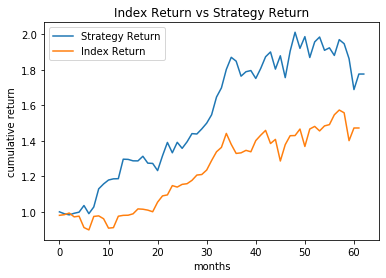

In [13]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+portfolio_return).cumprod())
plt.plot((1+DJI["mon_ret"][2:].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])